## Imports Useful Libraries

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import time
from datetime import timedelta

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

## Copy some of the data-dimensions for convenience.
img_size_flat is the number of pixels in an image when the image is flattened, img_size_flat = 28 * 28 = 784.

img_shape is the shape of an image in 2-D, img_shape = 28 * 28 (28 by 28).

num_classes is the number of output classes for the images, num_classes = 10

In [3]:
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes

## Define the placeholders for feeding the training and testing data to the computational graph
x is a placeholder variable whose dimensions are [None, img_size_flat] through which the images are fed to the model for training as well as testing.

y_true is the placeholder through which the correct class for a training or testing data is fed to the network.

In [4]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes]) # y_true is a one-hot vector of class labels
y_true_cls = tf.argmax(y_true, axis =1) # not a placeholder, y_true cls contains the class label as an integral value

## Define the model
Our model is a multi-layer perceptron with 4 hidden layers having 1000, 1000, 500 and 200 neurons respectively. For ease of simplicity, biases are not used in the model.

In [5]:
hidden1 = 1000
hidden2 = 1000
hidden3 = 500
hidden4 = 200

## Variables to be optimized
w1-w5 are 5 trainable variables that will be optimized during the training.

In [6]:
w1 = tf.Variable(tf.truncated_normal([img_size_flat,hidden1], stddev = 0.05, seed=25))
h1 = tf.nn.relu(tf.matmul(x,w1))

w2 = tf.Variable(tf.truncated_normal([hidden1,hidden2],stddev = 0.05, seed=25))
h2 = tf.nn.relu(tf.matmul(h1,w2))

w3 = tf.Variable(tf.truncated_normal([hidden2,hidden3], stddev = 0.05, seed=25))
h3 = tf.nn.relu(tf.matmul(h2,w3))

w4 = tf.Variable(tf.truncated_normal([hidden3,hidden4],stddev = 0.05, seed=25))
h4 = tf.nn.relu(tf.matmul(h3,w4))

w5 = tf.Variable(tf.truncated_normal([hidden4,num_classes], stddev = 0.05, seed=25))
logits = tf.matmul(h4,w5)

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

## Calculation of model loss
To understand and quantify the performance of the model, a cross-entropy loss is defined over the oputput of the model and true class values.

In [7]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [10]:
batch_size = 100

In [11]:
def optimize(optimizer, num_iterations):
    #start_time = time.time()
        
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        
    #end_time = time.time()
    #time_dif = end_time - start_time
    #print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [12]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

In [13]:
def print_accuracy():
    
    start_time = time.time()
    
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    end_time = time.time()
    
    timedelta = (end_time-start_time)*1000
    print("Execution time in milliseconds: {0:.4}".format(timedelta))
    
    return acc, timedelta

## Performance after 100 optimization iterations

In [14]:
optimize(optimizer, num_iterations=100)

In [15]:
original_accuracy, execution_time = print_accuracy()

Accuracy on test-set: 88.3%
Execution time in milliseconds: 542.2


## Performance after 2000 optimization iterations

In [16]:
# We have already performed 100 iterations.
optimize(optimizer, num_iterations=1900)

In [17]:
original_accuracy, execution_time = print_accuracy()

Accuracy on test-set: 97.6%
Execution time in milliseconds: 637.7


# Weight Pruning

In [18]:
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [19]:
def weight_pruning(sparsity):

    accuracy_weight_pruning = []
    
    for k in sparsity:
    
    # First, perform weight pruning by setting lower k1% weights to 0.
    
    # Set the lower k1% weight values to 0, reshape the numpy vector to the shape of the
    # original corresponding weight vector and convert the weight vector back to a tensor.    
    
    
        wt1 = np.ndarray.flatten(np.asarray(session.run(w1)))
        wt2 = np.ndarray.flatten(np.asarray(session.run(w2)))
        wt3 = np.ndarray.flatten(np.asarray(session.run(w3)))
        wt4 = np.ndarray.flatten(np.asarray(session.run(w4)))
        wt5 = np.asarray(session.run(w5))
        
        wt1[np.abs(wt1)<np.percentile(np.abs(wt1),k)] = 0
        wt2[np.abs(wt2)<np.percentile(np.abs(wt2),k)] = 0
        wt3[np.abs(wt3)<np.percentile(np.abs(wt3),k)] = 0
        wt4[np.abs(wt4)<np.percentile(np.abs(wt4),k)] = 0
    
    # The weight vectors obtained above are used to initialize the trainable parameters of the neural network.
    # The weight vectors are first reshaped into the shape corresponding to the layers they connect and then
    # converted to tensors so as to use them to initialize the weights of the neural network layers.
    
        wt1 = tf.Variable(tf.convert_to_tensor(wt1.reshape([img_size_flat,hidden1])))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2.reshape([hidden1,hidden2])))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3.reshape([hidden2,hidden3])))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4.reshape([hidden3,hidden4])))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
    
    # Apply softmax to logits to get predicted probabilities for each class and predicted class for 
    # each instance.
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
    
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
    
        acc = session.run(accuracy, feed_dict = feed_dict_test)
        accuracy_weight_pruning.append(acc*100)
    
    return accuracy_weight_pruning
    
    #####################################################################################################
    
    

In [20]:
accuracy_weight_pruning = weight_pruning(sparsity)

In [21]:
accuracy_weight_pruning

[97.57000207901001,
 97.42000102996826,
 96.71000242233276,
 95.69000005722046,
 95.08000016212463,
 76.69000029563904,
 32.440000772476196,
 21.410000324249268,
 17.839999496936798,
 11.159999668598175]

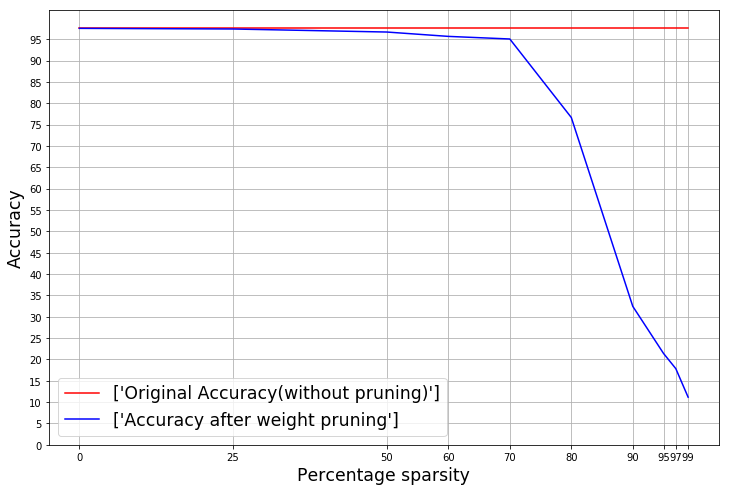

In [22]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r', sparsity,accuracy_weight_pruning,'b')
plt.grid()
plt.legend([['Original Accuracy(without pruning)'],['Accuracy after weight pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

# Unit/Neuron Pruning

In [23]:
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [24]:
def neuron_pruning(sparsity):
    
    accuracy_neuron_pruning = []
    neuron_pruning_testing_execution_time = []
    for k in sparsity:
        
        wt1 = np.asarray(session.run(w1))
        wt2 = np.asarray(session.run(w2))
        wt3 = np.asarray(session.run(w3))
        wt4 = np.asarray(session.run(w4))
        wt5 = np.asarray(session.run(w5))

        norm1 = LA.norm(wt1, axis=0)
        norm2 = LA.norm(wt2, axis=0)
        norm3 = LA.norm(wt3, axis=0)
        norm4 = LA.norm(wt4, axis=0)
        
        wt1[:,np.argwhere(norm1<np.percentile(norm1,k))] = 0
        wt2[:,np.argwhere(norm2<np.percentile(norm2,k))] = 0
        wt3[:,np.argwhere(norm3<np.percentile(norm3,k))] = 0
        wt4[:,np.argwhere(norm4<np.percentile(norm4,k))] = 0
        
        wt1 = tf.Variable(tf.convert_to_tensor(wt1))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
    
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
    
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
    
        acc = session.run(accuracy, feed_dict = feed_dict_test)
        accuracy_neuron_pruning.append(acc*100)
    
    return accuracy_neuron_pruning, neuron_pruning_testing_execution_time

    #####################################################################################################
    

In [25]:
accuracy_neuron_pruning, neuron_pruning_testing_execution_time = neuron_pruning(sparsity)

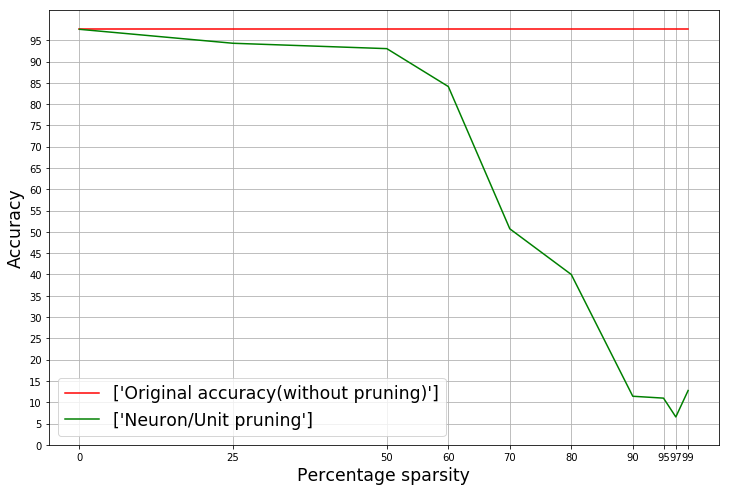

In [26]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r', sparsity,accuracy_neuron_pruning,'g')
plt.grid()
plt.legend([['Original accuracy(without pruning)'],['Neuron/Unit pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

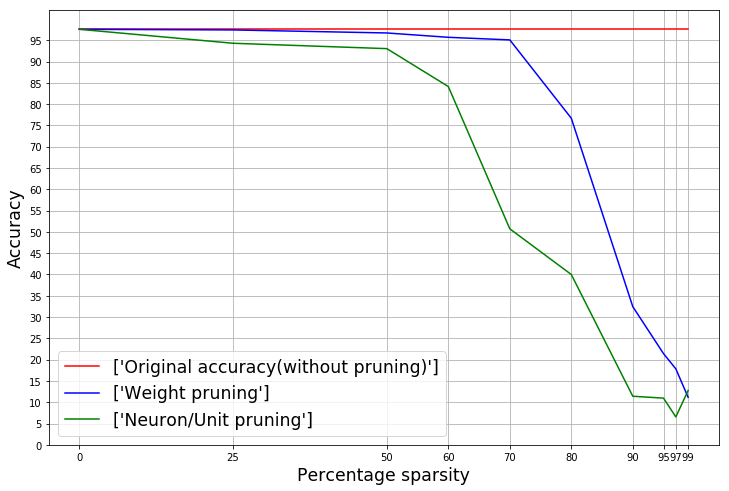

In [27]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r',
         sparsity, accuracy_weight_pruning,'b',sparsity,accuracy_neuron_pruning,'g')
plt.grid()
plt.legend([['Original accuracy(without pruning)'],['Weight pruning'],['Neuron/Unit pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

# Recovery analysis when weight pruned network is trained again

Here, I tried to train the sparse neural network again to check whether it achieves the same testing accuracy as before, i.e, whether the network is able to recover its potential for classification or not.

Recovery analysis is performed for all the sparsity values for which the network was initially pruned.

In [28]:
def retrain_weight_pruning(sparsity,num_iterations):

    retrain_accuracy_weight_pruning = []
    
    for k in sparsity:
    
        wt1 = np.ndarray.flatten(np.asarray(session.run(w1)))
        wt2 = np.ndarray.flatten(np.asarray(session.run(w2)))
        wt3 = np.ndarray.flatten(np.asarray(session.run(w3)))
        wt4 = np.ndarray.flatten(np.asarray(session.run(w4)))
        wt5 = np.asarray(session.run(w5))
    # First, perform weight pruning by setting lower k1% weights to 0.
    
    # Set the lower k1% weight values to 0, reshape the numpy vector to the shape of the
    # original corresponding weight vector and convert the weight vector back to a tensor.    
    
        wt1[np.abs(wt1)<np.percentile(np.abs(wt1),k)] = 0
        wt2[np.abs(wt2)<np.percentile(np.abs(wt2),k)] = 0
        wt3[np.abs(wt3)<np.percentile(np.abs(wt3),k)] = 0
        wt4[np.abs(wt4)<np.percentile(np.abs(wt4),k)] = 0
    
    # The weight vectors obtained above are used to initialize the trainable parameters of the neural network.
    # The weight vectors are first reshaped into the shape corresponding to the layers they connect and then
    # converted to tensors so as to use them to initialize the weights of the neural network layers.
    
        wt1 = tf.Variable(tf.convert_to_tensor(wt1.reshape([img_size_flat,hidden1])))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2.reshape([hidden1,hidden2])))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3.reshape([hidden2,hidden3])))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4.reshape([hidden3,hidden4])))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
        
    # Apply softmax to logits to get predicted probabilities for each class and predicted class for 
    # each instance.
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
    
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
        cost = tf.reduce_mean(cross_entropy)
    
    
        optimizer_wp = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
            
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
        
        
        optimize(optimizer_wp, num_iterations)
    
        acc = session.run(accuracy, feed_dict = feed_dict_test)
        retrain_accuracy_weight_pruning.append(acc*100)
    
    return retrain_accuracy_weight_pruning
    
    #####################################################################################################
    
    

In [29]:
retrain_accuracy_weight_pruning = retrain_weight_pruning(sparsity,500)

In [30]:
retrain_accuracy_weight_pruning

[97.45000004768372,
 97.10999727249146,
 97.5600004196167,
 97.04999923706055,
 97.39000201225281,
 97.17000126838684,
 95.67000269889832,
 95.21999955177307,
 94.87000107765198,
 93.09999942779541]

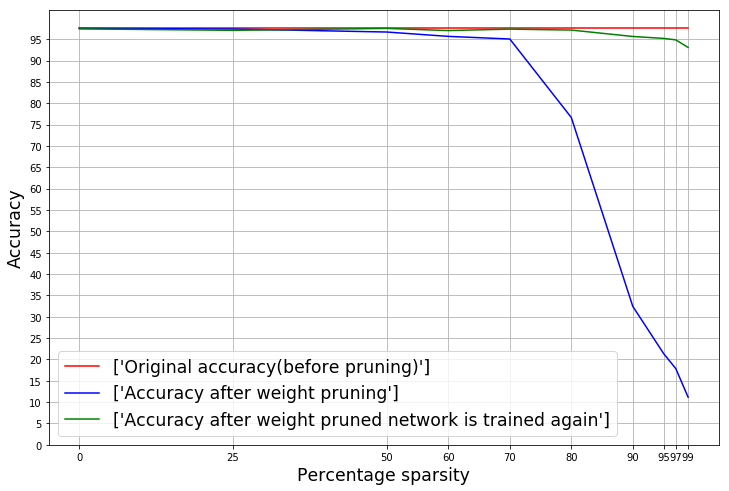

In [31]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r',
         sparsity,accuracy_weight_pruning,'b',
         sparsity,retrain_accuracy_weight_pruning,'g')

plt.grid()

plt.legend([['Original accuracy(before pruning)'],
            ['Accuracy after weight pruning'],
            ['Accuracy after weight pruned network is trained again']],
           loc='lower left', fontsize='xx-large')

plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Accuracy',fontsize='xx-large')

plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))

plt.show()

# Recovery analysis when unit/neuron pruned network is trained again

In [35]:
def retrain_neuron_pruning(sparsity,num_iterations):

    retrain_accuracy_neuron_pruning = []
    #neuron_pruning_testing_execution_time = []
    
    for k in sparsity:
    
        wt1 = np.asarray(session.run(w1))
        wt2 = np.asarray(session.run(w2))
        wt3 = np.asarray(session.run(w3))
        wt4 = np.asarray(session.run(w4))
        wt5 = np.asarray(session.run(w5))

        norm1 = LA.norm(wt1, axis=0)
        norm2 = LA.norm(wt2, axis=0)
        norm3 = LA.norm(wt3, axis=0)
        norm4 = LA.norm(wt4, axis=0)
        
        wt1[:,np.argwhere(norm1<np.percentile(norm1,k))] = 0
        wt2[:,np.argwhere(norm2<np.percentile(norm2,k))] = 0
        wt3[:,np.argwhere(norm3<np.percentile(norm3,k))] = 0
        wt4[:,np.argwhere(norm4<np.percentile(norm4,k))] = 0
        
        wt1 = tf.Variable(tf.convert_to_tensor(wt1))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
    
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
    
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
        cost = tf.reduce_mean(cross_entropy)
    
    
        optimizer_np = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
            
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
        
        
        optimize(optimizer_np, num_iterations)
        
        start_time = time.time()
        acc = session.run(accuracy, feed_dict = feed_dict_test)
        duration = time.time() - start_time
        
        retrain_accuracy_neuron_pruning.append(acc*100)
        neuron_pruning_testing_execution_time.append(duration*1000)
        
    
    return retrain_accuracy_neuron_pruning

    ####################################################################################################

In [38]:
retrain_accuracy_neuron_pruning = retrain_neuron_pruning(sparsity, 50)

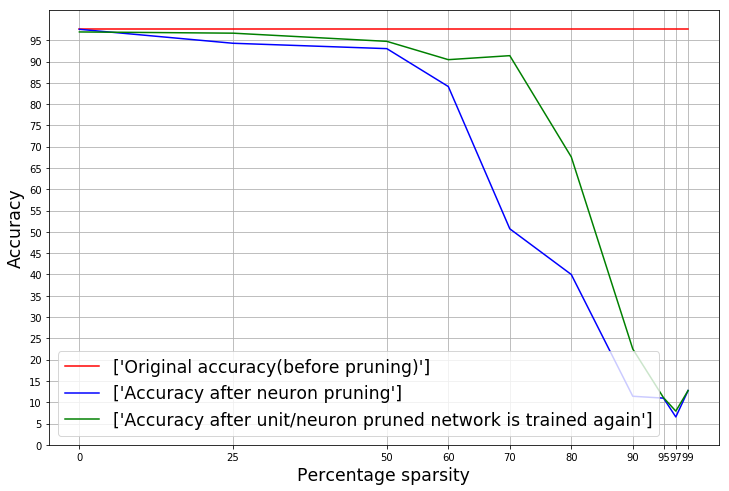

In [39]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r',
         sparsity,accuracy_neuron_pruning,'b',
         sparsity,retrain_accuracy_neuron_pruning,'g')

plt.grid()

plt.legend([['Original accuracy(before pruning)'],
            ['Accuracy after neuron pruning'],
            ['Accuracy after unit/neuron pruned network is trained again']],
           loc='lower left', fontsize='xx-large')

plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Accuracy',fontsize='xx-large')

plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))

plt.show()

# Increasing the speed of execution of the neural net using neuron pruning

In [40]:
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [41]:
def execution_speed(sparsity):
    
    execution_time = []
    accuracy_smaller_network = []
    
    for k in sparsity:
        
        
        wt1 = np.asarray(session.run(w1))
        wt2 = np.asarray(session.run(w2))
        wt3 = np.asarray(session.run(w3))
        wt4 = np.asarray(session.run(w4))
        wt5 = np.asarray(session.run(w5))

        norm1 = LA.norm(wt1, axis=0)
        norm2 = LA.norm(wt2, axis=0)
        norm3 = LA.norm(wt3, axis=0)
        norm4 = LA.norm(wt4, axis=0)
        
        
        wt1[:,np.argwhere(norm1<np.percentile(norm1,k))] = 0
        wt2[:,np.argwhere(norm2<np.percentile(norm2,k))] = 0
        wt3[:,np.argwhere(norm3<np.percentile(norm3,k))] = 0
        wt4[:,np.argwhere(norm4<np.percentile(norm4,k))] = 0
        
        
        # columns with norm = 0 in wt1
        index1 = np.argwhere(wt1[0,:]==0)
        wt1 = np.delete(wt1,index1,axis=1)
        
        # columns with norm = 0 in wt2
        index2 = np.argwhere(wt2[0,:]==0)
        # delete rows with index same as columns deleted in wt_1
        wt2 = np.delete(wt2,index1,axis=0)
        #axis=0 means delete rows
        wt2 = np.delete(wt2,index2,axis=1)
        #axis=1 means delete column
        
        index3 = np.argwhere(wt3[0,:]==0)
        wt3 = np.delete(wt3,index2,axis=0)
        wt3 = np.delete(wt3,index3,axis=1)
        
        wt4 = np.delete(wt4,index3,axis=0)
        
        
        ############################################################
        
        
        wt1 = tf.Variable(tf.convert_to_tensor(wt1))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
    
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
    
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        accuracy_np = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
        
        start_time = time.time()
        acc = session.run(accuracy_np, feed_dict = feed_dict_test)
        duration = time.time() - start_time
        
        
        accuracy_smaller_network.append(100*acc)
        execution_time.append(duration*1000)
        
    return (accuracy_smaller_network, execution_time)

In [42]:
accuracy_smaller_network, execution_time = execution_speed(sparsity)

In [43]:
accuracy_smaller_network

[97.57000207901001,
 94.2900002002716,
 93.02999973297119,
 84.13000106811523,
 50.72000026702881,
 39.98999893665314,
 11.400000005960464,
 10.96000000834465,
 6.539999693632126,
 12.749999761581421]

In [44]:
execution_time

[856.8398952484131,
 726.4430522918701,
 527.8198719024658,
 534.2662334442139,
 465.2543067932129,
 432.86681175231934,
 375.9310245513916,
 405.9889316558838,
 399.7528553009033,
 375.5209445953369]

In [45]:
neuron_pruning_testing_execution_time

[853.9512157440186,
 894.7062492370605,
 789.8597717285156,
 798.7017631530762,
 821.57301902771,
 804.589033126831,
 808.7868690490723,
 820.5890655517578,
 819.5838928222656,
 830.3849697113037]